In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler, abc_rejection_sampler2
import seaborn as sns
from scipy.stats import norm, lognorm, multivariate_normal
from src.utils import get_results

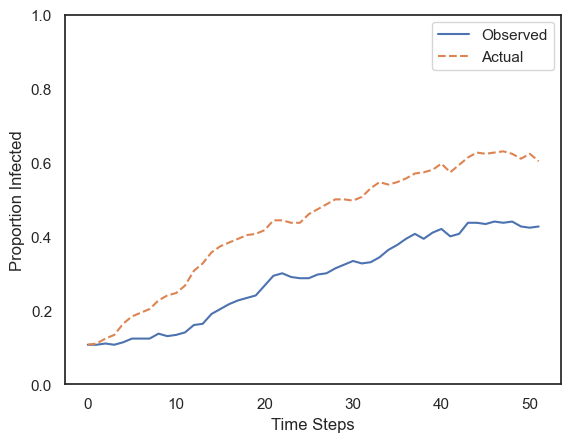

In [152]:
sns.set_theme()
sns.set_style("white")
sns.set_palette("deep")
beta_true = [0.05, .02, .04, .06, .08, .1, .05]
alpha = 0.1
gamma = 0.05
eta = 0.1 # interpretation: after one week, a colonized patient will show symptoms with probability .5
heterogeneous = True
N = 300 # consider increasing
T = 52
K = 30
data_seed = 31
prior_mu = [-3, -3, -3, -3, -3, -3, -3]
prior_sigma = [1, 1, 1, 1, 1, 1, 1]

si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed, eta=eta)
y_o = si_model.get_observed_data()


si_model_alt = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, flatten=False,
                  observed_seed=data_seed, eta=.999)

x_o = si_model_alt.get_observed_data()


sns.lineplot(y_o[0, :], label="Observed")
sns.lineplot(x_o[0, :], label="Actual", linestyle="--")

plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/partial_obs.png")
plt.show()

In [257]:
y_o.mean(1)

tensor([0.2855, 0.2160, 0.2458, 0.3151, 0.3670, 0.2837, 0.1024])

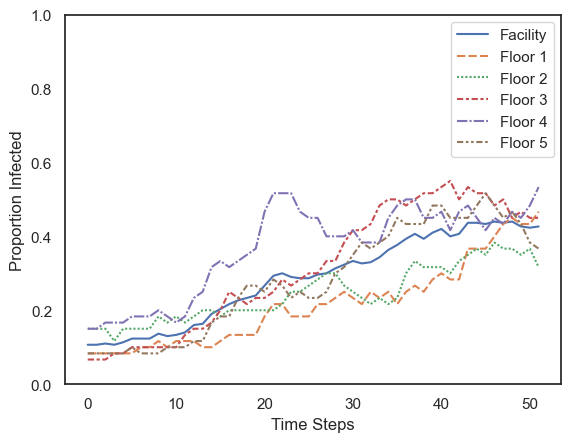

In [153]:
data = y_o[:6,:]

data = pd.DataFrame(data = data.T, columns=["Facility"] + [f"Floor {i}" for i in range(1,6)])

sns.lineplot(data)
plt.ylim((0,1))
plt.xlabel("Time Steps")
plt.ylabel("Proportion Infected")
plt.savefig("images/partial_obs_floor_viz.png")
plt.show()

# Partial Observation

In [268]:
df_partial = get_results("../multirun/2024-11-04/15-42-44").sort_values("val_loss")

In [269]:
mu = df_partial.iloc[0]["mu"][0]
sigma = df_partial.iloc[0]["sigma"]

In [88]:
# j = 1
# mu = eval(df_partial["mu"].values[j])[0]
# # mu

# sigma = eval(df_partial["sigma"].values[j])
# sds = [sigma[i][i]**0.5 for i in range(7)]
# # sds

# npe_rates = [np.exp(mu[i] + sds[i]**2/2) for i in range(7)]

# ABC

In [195]:
si_model = SIModel(alpha, gamma, beta_true, heterogeneous,
                  prior_mu, prior_sigma, N=N, T=T, summarize=False, eta=0.1)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(31)

epsilon = 1.3

S = 100
print(f"epsilon: {epsilon}")
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
    print_every=1000, summarize=False
    )

epsilon: 1.3
Attempts: 1,000
Attempts: 2,000
Attempts: 3,000
Attempts: 4,000
Attempts: 5,000
Attempts: 6,000
Attempts: 7,000
Attempts: 8,000
Attempts: 9,000
Attempts: 10,000
Attempts: 11,000
Attempts: 12,000
Time lapsed: 202.39 seconds
With tolerance 1.3, acceptance rate: 0.008135
Total number of attempts: 12,292


In [194]:
np.quantile(errors[errors > 0], 0.005)

1.2745239966457642

In [196]:
abc_rates = np.exp(posterior_sample).mean(0)

a = np.quantile(np.exp(posterior_sample), 0.05, 0)
b = np.quantile(np.exp(posterior_sample), 0.95, 0)

abc_cis = list(zip(a, b))

In [203]:
a = np.sort(errors[errors > 0])

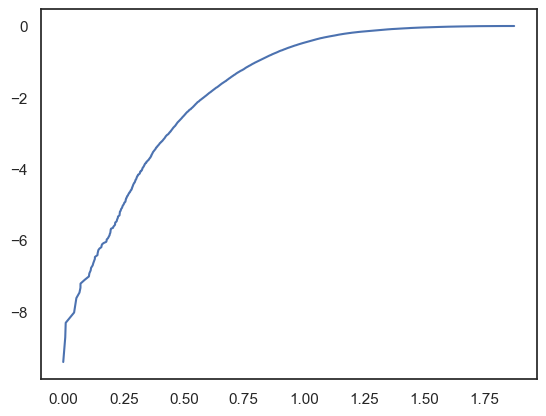

In [227]:
x = np.sort(a)
y = np.arange(len(x))/float(len(x))
plt.plot(x[1:], np.log(y[1:]))

# wrong way to visualize this imo

## Build Table

In [184]:
# 90% credible intervals
npe_cis = []
for i in range(7):
    sd = sigma[i][i]**0.5
    dist = norm(mu[i], sd)
    a, b = dist.ppf(0.05), dist.ppf(0.95)
    npe_cis.append((a, b))
    # print(np.round(np.exp(a), 3), np.round(np.exp(b), 3))

In [185]:
npe_cis

[(0.027914958941121233, 0.09507635707936749),
 (-0.023485140753965475, 0.06647178704855927),
 (-0.021367928407799504, 0.08388659956277536),
 (0.01996107742795626, 0.14501899137487728),
 (0.022252608352410636, 0.17519081730295433),
 (-0.032540781240939634, 0.10232628677415799),
 (-0.01117141617417984, 0.1241596422898834)]

In [199]:
abc_cis

[(0.023227868601679802, 0.09808381758630276),
 (0.006043981737457216, 0.07279214560985565),
 (0.008620506874285639, 0.07525781989097594),
 (0.01773008853197098, 0.152433492988348),
 (0.02260046871379018, 0.1859229102730751),
 (0.010375760262832046, 0.10967215932905675),
 (0.011422247812151908, 0.17700220122933386)]

In [187]:
table = pd.DataFrame({
    "Transmission Rate": ["Facility"] + [f"Floor {i}" for i in range(1, 6)] + ["Room"],
    "Value": [0.05, 0.02, 0.04, 0.06, 0.08, 0.1, 0.05],
    "NPE Mean": mu,
    "NPE CI": npe_cis,
    "ABC Mean": abc_rates,
    "ABC CI": abc_cis
})

In [188]:
# possibly need to show posterior predictive checks to show that NPE does a better job...
print(table.to_latex())

\begin{tabular}{llrrlrl}
\toprule
 & Transmission Rate & Value & NPE Mean & NPE CI & ABC Mean & ABC CI \\
\midrule
0 & Facility & 0.050000 & 0.061496 & (0.027914958941121233, 0.09507635707936749) & 0.052025 & (0.014915673155337572, 0.10280651710927485) \\
1 & Floor 1 & 0.020000 & 0.021493 & (-0.023485140753965475, 0.06647178704855927) & 0.034074 & (0.00755172623321414, 0.07069381587207317) \\
2 & Floor 2 & 0.040000 & 0.031259 & (-0.021367928407799504, 0.08388659956277536) & 0.034953 & (0.011918449634686112, 0.08151228241622444) \\
3 & Floor 3 & 0.060000 & 0.082490 & (0.01996107742795626, 0.14501899137487728) & 0.068444 & (0.013566494593396783, 0.14579947516322136) \\
4 & Floor 4 & 0.080000 & 0.098722 & (0.022252608352410636, 0.17519081730295433) & 0.091224 & (0.012722200201824307, 0.21136066392064093) \\
5 & Floor 5 & 0.100000 & 0.034893 & (-0.032540781240939634, 0.10232628677415799) & 0.057751 & (0.01012819386087358, 0.12092284597456454) \\
6 & Room & 0.050000 & 0.056494 & (-0.0111714

## Posterior Predictive Checks

In [300]:
neural_posterior = multivariate_normal(mu, sigma)
K = 30
npe_sample = np.empty((0,7))
seed = 2
while npe_sample.shape[0] < K:
    draw = neural_posterior.rvs(size=K, random_state=seed)
    seed += 1
    accepted = draw[(draw > 0).all(axis=1)]
    npe_sample = np.concatenate((npe_sample, accepted), axis=0)
npe_sample = npe_sample[:K]

In [329]:
def posterior_predictive(sample, K=30):
    posterior_predictive = np.empty((K, 7, T))
    si_model = SIModel(alpha, gamma, beta_true, 
                       heterogeneous, prior_mu, prior_sigma, 
                       N, T, summarize=False, observed_seed=31,
                       flatten=False, eta = 0.1)
    x_o = si_model.get_observed_data()
    
    for i in range(K):
        si_model = SIModel(alpha, gamma, sample[i], 
                       heterogeneous, prior_mu, prior_sigma,
                       N, T, summarize=False, flatten=False,
                          eta = 0.1)
        x_rep = si_model.get_observed_data(i)
        posterior_predictive[i] =  np.array(x_rep)
    return posterior_predictive

In [334]:
pp_abc = posterior_predictive(np.exp(posterior_sample))

In [366]:
def ppc_plotter(npe_sample, j, save_tag = None):
    posterior_predictive = np.empty((K, 7, T))
    si_model = SIModel(alpha, gamma, beta_true, 
                       heterogeneous, prior_mu, prior_sigma, 
                       N, T, summarize=False, observed_seed=31,
                       flatten=False, eta = 0.1)
    x_o = si_model.get_observed_data()
    
    for i in range(K):
        si_model = SIModel(alpha, gamma, npe_sample[i], 
                       heterogeneous, prior_mu, prior_sigma,
                       N, T, summarize=False, flatten=False,
                          eta = 0.1)
        x_rep = si_model.get_observed_data(i)
        posterior_predictive[i] =  np.array(x_rep)
    pp_mean = posterior_predictive.mean(0)[j]
    abc_mean = pp_abc.mean(0)[j]
    
    labels = ["Post. Pred. Draw (NPE)"] + [None for _ in range(K-1)]
    I_o = np.array(x_o)[j]
    S_o  = 1 - I_o
    plt.plot(I_o, label="Observed", color="k")
    plt.plot(posterior_predictive[:,j,:].T, 
             label=labels, color="b",
             alpha=0.2)
    plt.plot(pp_mean, label="Post. Pred. Mean (NPE)", linestyle="--",
             color="orange")
    plt.plot(abc_mean, label="Post. Pred. Mean (ABC)", linestyle=":", color="green")
    plt.legend()
    # plt.title("NPE Posterior Predictive Check")
    if j == 6:
        plt.ylabel("Proportion of Infected Roommates")
    else:
        plt.ylabel("Proportion Infected")
    plt.xlabel("Time Steps")
    # plt.ylim(0, 1)
    if save_tag is not None:
        plt.savefig(f"images/{save_tag}.png")
    
    plt.show()

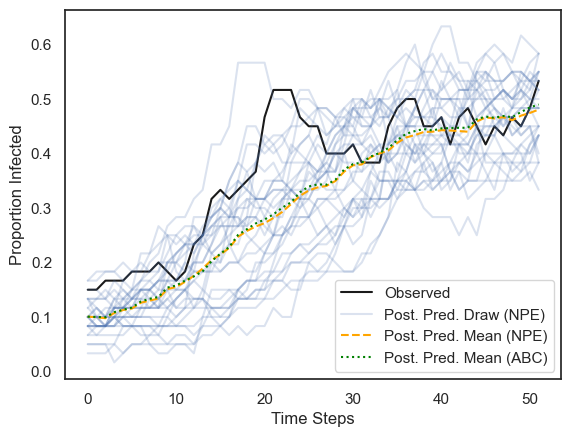

In [378]:
ppc_plotter(npe_sample, 4)

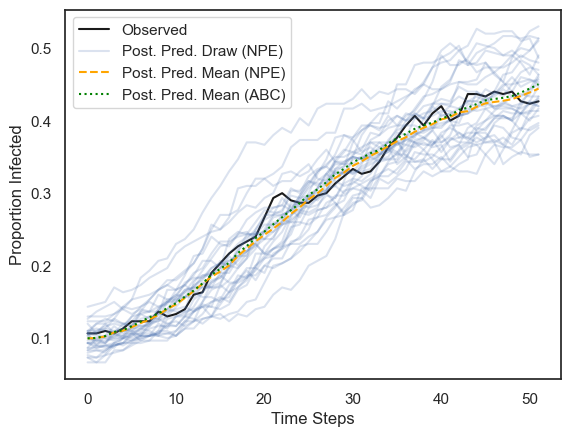

In [367]:
ppc_plotter(npe_sample, 0, "partial-ppc-a")

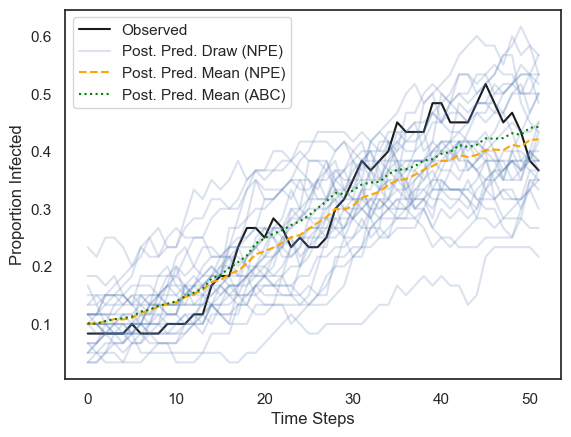

In [368]:
ppc_plotter(npe_sample, 5, "partial-ppc-b")

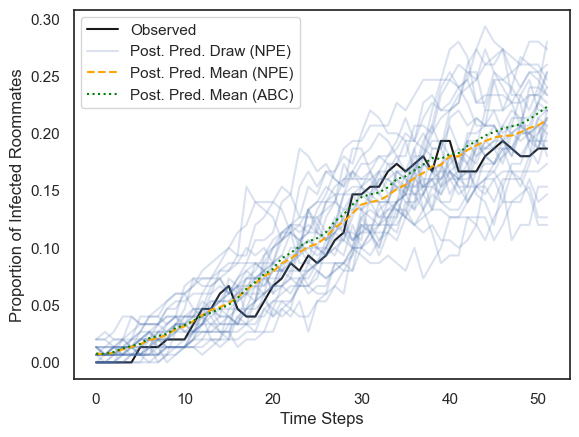

In [369]:
ppc_plotter(npe_sample, 6, "partial-ppc-c")

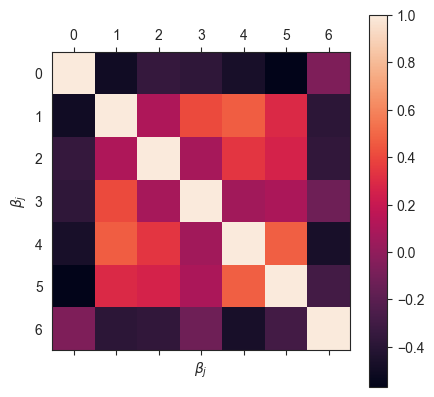

In [114]:
D = np.diag(1 / np.sqrt(np.diag(sigma)))
corr = D @ sigma @ D
plt.matshow(corr, cmap="rocket")
plt.colorbar()
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
# plt.savefig("images/corr.png")
plt.show()

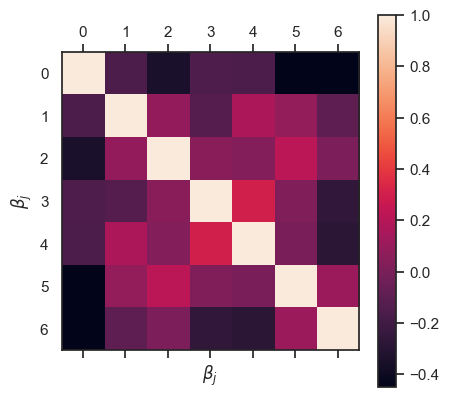

In [384]:
plt.matshow(np.corrcoef(np.exp(posterior_sample).T), cmap="rocket")
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
plt.colorbar()
plt.savefig("images/partial-corr-abc.png")

## modified NPE estimates

In [280]:
neural_posterior = multivariate_normal(mu, sigma)
K = 100
npe_sample2 = np.empty((0,7))
seed = 2
while npe_sample2.shape[0] < K:
    draw = neural_posterior.rvs(size=K, random_state=seed)
    seed += 1
    accepted = draw[(draw > 0).all(axis=1)]
    npe_sample2 = np.concatenate((npe_sample2, accepted), axis=0)
npe_sample2 = npe_sample2[:K]

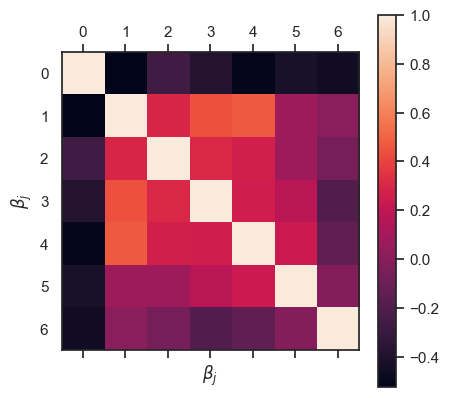

In [383]:
plt.matshow(np.corrcoef(npe_sample2.T), cmap="rocket")
plt.xlabel(r"$\beta_j$")
plt.ylabel(r"$\beta_j$")
plt.colorbar()
plt.savefig("images/partial-corr-npe.png")